In [1]:
import numpy as np
import copy as cp
import matplotlib.pyplot as plt
from timeit import default_timer as timer
import seaborn as sns
from typing import Tuple
from sklearn.metrics import confusion_matrix
import pandas as pd 
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import matthews_corrcoef

In [2]:
a = timer()
path = "diabetes_health_indicators.csv"
df = pd.read_csv(path)
df.head()
b = timer()
upload_time = b-a
upload_time

0.2816106999999999

In [3]:
df.head()

,Diabetes_012,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0


In [4]:
X = df.iloc[:,1:22]
y = df.iloc[:,0]

In [5]:
model_gini = DecisionTreeClassifier(criterion="gini")
model_entropy = DecisionTreeClassifier(criterion="entropy")

kfold = KFold(n_splits=5, random_state=42, shuffle=True)

In [6]:
def cross_val_predict(model, kfold : KFold, X : np.array, y : np.array) -> Tuple[np.array, np.array, np.array]:

    model_ = cp.deepcopy(model)
    modelCheck = cp.deepcopy(model)
    
    no_classes = len(np.unique(y))
    
    actual_classes = np.empty([0], dtype=int)
    actualCheck_classes = np.empty([0], dtype=int)
    predicted_classes = np.empty([0], dtype=int)
    predicted_proba = np.empty([0, no_classes]) 
    time = 0.0
    mcc_scores = []
    
    a = timer()
    for train_ndx, test_ndx in kfold.split(X):
       
        trainCheck_X, trainCheck_y, testCheck_X, testCheck_y = X[train_ndx], y[train_ndx], X[test_ndx], y[test_ndx]

        actualCheck_classes = np.append(actualCheck_classes, testCheck_y)
        
        modelCheck.fit(trainCheck_X, trainCheck_y)
        
    b = timer()
    delta = b - a
    time += delta 
    
    for train_ndx, test_ndx in kfold.split(X):
        train_X, train_y, test_X, test_y = X[train_ndx], y[train_ndx], X[test_ndx], y[test_ndx]

        actual_classes = np.append(actual_classes, test_y)
        
        model_.fit(train_X, train_y)
        
        predicted_classes = np.append(predicted_classes, model_.predict(test_X))
        
        mcc_scores.append(matthews_corrcoef(actual_classes, predicted_classes))

        try:
            predicted_proba = np.append(predicted_proba, model_.predict_proba(test_X), axis=0)
        except:
            predicted_proba = np.append(predicted_proba, np.zeros((len(test_X), no_classes), dtype=float), axis=0)

    return actual_classes, predicted_classes, predicted_proba, time, mcc_scores 

In [7]:
def plot_confusion_matrix(actual_classes : np.array, predicted_classes : np.array, sorted_labels : list):

    matrix = confusion_matrix(actual_classes, predicted_classes, labels=sorted_labels)
    
    plt.figure(figsize=(12.8,6))
    sns.heatmap(matrix, annot=True, xticklabels=sorted_labels, yticklabels=sorted_labels, cmap="Blues", fmt="g")
    plt.xlabel('Predicted'); plt.ylabel('Actual'); plt.title('Confusion Matrix')

    plt.show()

In [8]:
scores = cross_val_score(model_gini, X, y, cv=5)
print("The accuracy for the gini tree is: ", np.mean(scores))

The accuracy for the gini tree is:  0.7665326395458847


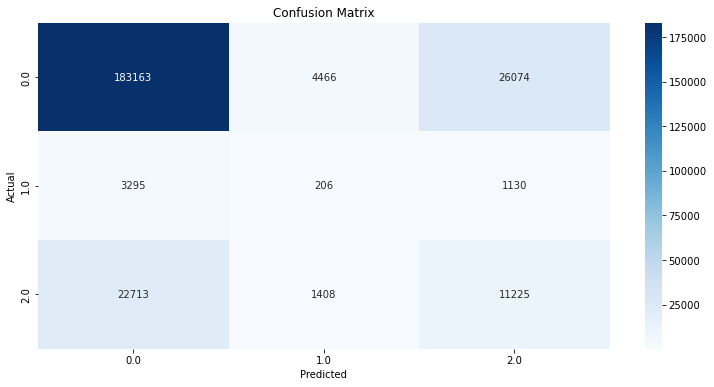

The generation time for gini index:  4.4522639999999996
The mcc score for gini index:  0.1812819593979458


In [9]:
actual_classes, predicted_classes, _, time, mcc_scores = cross_val_predict(model_gini, kfold, X.to_numpy(), y.to_numpy())
plot_confusion_matrix(actual_classes, predicted_classes, [0.0, 1.0, 2.0])
print("The generation time for gini index: ", time)
print("The mcc score for gini index: ", np.mean(mcc_scores))

In [10]:
scores = cross_val_score(model_entropy, X, y, cv=5)
print("The accuracy for the gini tree is: ", np.mean(scores))

The accuracy for the gini tree is:  0.7698675496688742


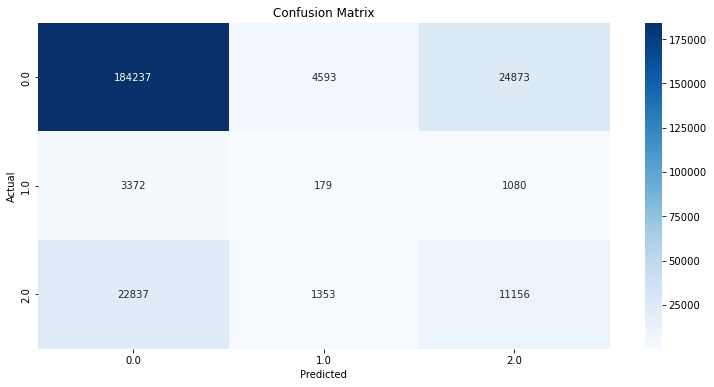

The generation time for information gain:  4.787675400000001
The mcc score for information gain:  0.18224731689209203


In [11]:
actual_classes, predicted_classes, _, time2, mcc_scores2 = cross_val_predict(model_entropy, kfold, X.to_numpy(), y.to_numpy())
plot_confusion_matrix(actual_classes, predicted_classes, [0.0, 1.0, 2.0])
print("The generation time for information gain: ", time2)
print("The mcc score for information gain: ", np.mean(mcc_scores2))